In [1]:
import sys
sys.path.append('../template_model')
from util import load_train_dev, Entry
import re
from collections import Counter, defaultdict

import warnings
warnings.filterwarnings('ignore')

RE_FIND_THIAGO_SLOT = re.compile('((?:AGENT-.)|(?:PATIENT-.)|(?:BRIDGE-.))')

def extract_orders(e):
    
    orders = Counter()
    
    for lexe in e.lexes:
        
        slots = RE_FIND_THIAGO_SLOT.findall(lexe['template'])
        positions = {}
        for i, k in enumerate(slots):
            if k not in positions:
                positions[k] = i
        positions = defaultdict(lambda: 10000, positions)
        sorted_triples = tuple(sorted(e.triples, key=lambda t: positions[e.r_entity_map[t.object]]))
        
        orders[sorted_triples] += 1
        
    return orders

In [2]:
all_td = load_train_dev()

# removendo entradas sem r_entity_map
td = [t for t in all_td if t.r_entity_map]

# Formulation (order_1, order_2, [-1, 0, 1])

In [95]:
from itertools import permutations, product, combinations
from collections import Counter

freq_first = defaultdict(Counter)
freq_last = defaultdict(Counter)
freq_1st_bigram = defaultdict(Counter)
freq_last_bigram = defaultdict(Counter)

for e in (e for e in td if len(e.triples) > 1):
    freq_first[len(e.triples)][e.triples[0].predicate] += 1
    freq_last[len(e.triples)][e.triples[-1].predicate] += 1
    freq_1st_bigram[len(e.triples)][(e.triples[0].predicate, e.triples[1].predicate)] += 1
    freq_last_bigram[len(e.triples)][(e.triples[-2].predicate, e.triples[-1].predicate)] += 1

def extract_features(order, e):
    
    if len(e.triples) > 1:
        freq_1st_bi = freq_1st_bigram[len(e.triples)][(order[0].predicate, order[1].predicate)]
    else:
        freq_1st_bi = 0
        
    if len(e.triples) > 1:
        freq_last_bi = freq_last_bigram[len(e.triples)][(order[-2].predicate, order[-1].predicate)]
    else:
        freq_last_bi = 0
    
    return {'is_first_order': order == abstract_triples(e.triples), 
            'freq_first': freq_first[len(e.triples)][order[0].predicate],
            'freq_last': freq_last[len(e.triples)][order[-1].predicate],
            'freq_1st_bigram': freq_1st_bi,
            'freq_last_bigram': freq_last_bi}

def merge_features(l1_features, l2_features):
    
    features_merged = {'{}_1'.format(k): v for k, v in l1_features.items()}
    features_merged.update({'{}_2'.format(k): v for k, v in l2_features.items()})
    
    return features_merged

def make_entries(e):
    
    X = []
    y = []
    
    all_orders = permutations(e.triples)
    all_abstracted_orders = set([abstract_triples(ts) for ts in all_orders])
    
    lexicalized_orders = extract_orders(e)
    
    for l1, l2 in product(lexicalized_orders.keys(), 
                          all_abstracted_orders - lexicalized_orders.keys()):
        
        X.append((l1, l2, e))
        y.append(1)
        X.append((l2, l1, e))
        y.append(-1)
        
    for l1 in all_abstracted_orders:
        
        X.append((l1, l1, e))
        y.append(0)
        
    return X, y

In [96]:
from sklearn.model_selection import train_test_split

X = []
y = []

for e in [t for t in td if len(t.triples) == 3]:
    
    len_triples = len(e.triples)
    
    e_X, e_y = make_entries(e)
    X.extend(e_X)
    y.extend(e_y)
    
len(X)

29059

In [97]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [98]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class ExtraiFeatures(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        results = []
        
        for x in X:
            x0 = x[0]
            x1 = x[1]
            e = x[2]
            
            x0_features = extract_features(x0, e)
            x1_features = extract_features(x1, e)
            
            features = merge_features(x0_features, x1_features)
            
            results.append(features)
        
        return results
            

data_pipeline = Pipeline([
    ('featurizer', ExtraiFeatures()),
    ('vectorizer', DictVectorizer(sparse=False)),
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler())
])

In [99]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


pipeline = Pipeline([
    ('data', data_pipeline),
    ('clf', LinearRegression())
])

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('data',
                 Pipeline(memory=None,
                          steps=[('featurizer', ExtraiFeatures()),
                                 ('vectorizer',
                                  DictVectorizer(dtype=<class 'numpy.float64'>,
                                                 separator='=', sort=True,
                                                 sparse=False)),
                                 ('poly',
                                  PolynomialFeatures(degree=2,
                                                     include_bias=True,
                                                     interaction_only=False,
                                                     order='C')),
                                 ('scaler',
                                  StandardScaler(copy=True, with_mean=True,
                                                 with_std=True))],
                          verbose=False)),
                ('clf',
     

In [100]:
import numpy as np

y_pred = pipeline.predict(X_train)

np.sqrt(mean_squared_error(y_train, y_pred))

0.7803948912225482

In [101]:
y_train[:10]

[1, 1, 1, -1, 1, 1, -1, 1, 0, -1]

In [102]:
y_pred[:10]

array([ 0.54140854, -0.02063751,  0.08896065, -0.30810356, -0.70025635,
        0.39338493, -0.24162102, -0.10328102, -0.00248528, -0.916502  ])

In [107]:
# using

e = td[3456]
e.triples

[Triple(subject='Aurakles', predicate='creator', object='Dick_Dillin'),
 Triple(subject='Dick_Dillin', predicate='nationality', object='United_States'),
 Triple(subject='Aurakles', predicate='alternativeName', object='Aurakles')]

In [108]:
extract_orders(e)
# creator > nationality > alternativeName
# alternativeName > creator > nationality

Counter({(Triple(subject='slot0', predicate='creator', object='slot1'),
          Triple(subject='slot1', predicate='nationality', object='slot2'),
          Triple(subject='slot0', predicate='alternativeName', object='slot0')): 1,
         (Triple(subject='slot0', predicate='alternativeName', object='slot0'),
          Triple(subject='slot0', predicate='creator', object='slot1'),
          Triple(subject='slot1', predicate='nationality', object='slot2')): 1})

In [119]:
orders = list(permutations(e.triples))

ordered = [orders[0]]

for o in orders:
    
    y = pipeline.predict([(ordered[-1], o, e)])
    
    if y >= 0:
        ordered.append(o)
    else:
        for i, o_ in enumerate(orders[:-1]):
            y = pipeline.predict([(o, o_, e)])
            
            if y >= 0:
                ordered.insert(i+1, o)

# Não acredito que Learning to Rank se aplique -> há sempre várias ordens possíveis... em learning to rank espera-se apenas uma ordem

# Formulation (order, [0, 1])

In [51]:
from itertools import permutations, product, combinations


def extract_features(order, e):
    
    return {'order': order, 
            'category': e.category,
            'n_triples': len(e.triples),
            'is_first_order': order == abstract_triples(e.triples)}

def make_entries(e):
    
    data = []
    
    all_orders = permutations(e.triples)
    all_abstracted_orders = set([abstract_triples(ts) for ts in all_orders])
    
    features = {order: extract_features(order, e) for order in all_abstracted_orders}
    
    lexicalized_orders = extract_orders(e)
    
    for l in lexicalized_orders.keys():
        
        l_features = extract_features(l, e)
        
        data.append((l_features, 1))
    
    for l in all_abstracted_orders - lexicalized_orders.keys():
        
        l_features = extract_features(l, e)
        
        data.append((l_features, 0))
        
    return data

In [76]:
data = []

for t in td[:6000]:
    x = make_entries(t)
    data.extend(x)

In [77]:
df = pd.DataFrame([c[0] for c in data])
df['target'] = [c[1] for c in data]

df.groupby(['n_triples', 'is_first_order', 'target']).size().unstack(fill_value=0)

target                        0     1
n_triples is_first_order             
1         True                0  1788
2         False             383   796
          True              248   960
3         False            4363  1958
          True              732   618
4         False           24830  2544
          True             1030   264
5         False           37873   827
          True              347    13

In [78]:
df.head()

,category,is_first_order,n_triples,order,target
0,Airport,True,1,"((slot0, cityServed, slot1),)",1
1,Airport,True,1,"((slot0, cityServed, slot1),)",1
2,Airport,True,1,"((slot0, elevationAboveTheSeaLevel_(in_metres)...",1
3,Airport,True,1,"((slot0, location, slot1),)",1
4,Airport,True,1,"((slot0, operatingOrganisation, slot1),)",1


In [97]:
from sklearn.model_selection import train_test_split

X = df[['category', 'is_first_order', 'n_triples']]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=df['target'])

X_train.shape, X_test.shape

((63659, 3), (15915, 3))

In [101]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

data_pipeline = Pipeline([
    ('ohe', OneHotEncoder())
])

pipeline = Pipeline([
    ('data', data_pipeline),
    ('clf', None)
])

params_grid = {
    'clf': [LogisticRegression(solver='lbfgs'), DecisionTreeClassifier(), RandomForestClassifier()]
}

cv = GridSearchCV(pipeline, params_grid, cv=5, scoring='recall')

cv.fit(X_train, y_train)

cv.best_estimator_

C:\ProgramData\Anaconda3\envs\webnlg\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('data',
                 Pipeline(memory=None,
                          steps=[('ohe',
                                  OneHotEncoder(categorical_features=None,
                                                categories=None, drop=None,
                                                dtype=<class 'numpy.float64'>,
                                                handle_unknown='error',
                                                n_values=None, sparse=True))],
                          verbose=False)),
                ('clf',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                      

In [102]:
cv.best_score_

0.38349306269122846

In [103]:
model = cv.best_estimator_

y_pred = cv.predict(X_train)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train, y_pred)

pd.DataFrame(cm, index=['not_good', 'good'], columns=['not_choosen', 'choosen'])

,not_choosen,choosen
not_good,55283,562
good,4853,2961


# Formulation ({order:{0, 1} for order in orders})

In [121]:
from itertools import permutations, product, combinations
from collections import Counter

freq_first = defaultdict(Counter)
freq_last = defaultdict(Counter)
freq_1st_bigram = defaultdict(Counter)
freq_last_bigram = defaultdict(Counter)

for e in (e for e in td if len(e.triples) > 1):
    freq_first[len(e.triples)][e.triples[0].predicate] += 1
    freq_last[len(e.triples)][e.triples[-1].predicate] += 1
    freq_1st_bigram[len(e.triples)][(e.triples[0].predicate, e.triples[1].predicate)] += 1
    freq_last_bigram[len(e.triples)][(e.triples[-2].predicate, e.triples[-1].predicate)] += 1

def extract_features(order, e):
    
    if len(e.triples) > 1:
        freq_1st_bi = freq_1st_bigram[len(e.triples)][(order[0].predicate, order[1].predicate)]
    else:
        freq_1st_bi = 0
        
    if len(e.triples) > 1:
        freq_last_bi = freq_last_bigram[len(e.triples)][(order[-2].predicate, order[-1].predicate)]
    else:
        freq_last_bi = 0
    
    return {'category': e.category,
            'n_triples': len(e.triples),
            'is_first_order': order == abstract_triples(e.triples), 
            'freq_first': freq_first[len(e.triples)][order[0].predicate],
            'freq_last': freq_last[len(e.triples)][order[-1].predicate],
            'freq_1st_bigram': freq_1st_bi,
            'freq_last_bigram': freq_last_bi}

def make_entries(e):
    
    all_orders = permutations(e.triples)
    all_abstracted_orders = set([abstract_triples(ts) for ts in all_orders])
    
    lexicalized_orders = extract_orders(e)
    
    features = {order: extract_features(order, e) for order in all_abstracted_orders}
    
    all_orders_features = []
    ok_orders = set()
    
    for i, order in enumerate(all_abstracted_orders):
        
        all_orders_features.append(features[order])
        
        if order in lexicalized_orders:
            
            ok_orders.add(i)
    
    return all_abstracted_orders, all_orders_features, ok_orders

In [122]:
from sklearn.model_selection import train_test_split

orders = defaultdict(list)
X = defaultdict(list)
y = defaultdict(list)

for e in td:
    
    len_triples = len(e.triples)
    
    all_orders, all_orders_features, ok_orders = make_entries(e)
    orders[len_triples].append(all_orders)
    X[len_triples].append(all_orders_features)
    y[len_triples].append(ok_orders)

In [123]:
# testing for len_triples = 3

X_train, X_test, y_train, y_test = train_test_split(X[4], y[4], test_size=.2)

sum(len(x) for x in X_train), sum(len(x) for x in X_test)

(25728, 6564)

In [124]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class MyModel(BaseEstimator, RegressorMixin):
    
    def __init__(self, clf=None):
        self.clf=clf
    
    def fit(self, X, y):
        
        X_ = []
        y_ = []
        
        for x, y__ in zip(X, y):
            
            for i, x_ in enumerate(x):
                
                X_.append(x_.todense())
                y_.append(1 if i in y__ else 0)
                
        X_ = np.vstack(X_)
        self.clf.fit(X_, y_)
        
        return self
    
    def predict(self, X):
        
        results = []
        
        for x in X:
            pred = self.clf.predict(x)
            result = {i for i in range(len(pred)) if pred[i] == 1}
            results.append(result)
            
        return results

In [125]:
from sklearn.base import BaseEstimator, TransformerMixin

class MyTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, data_pipeline):
        self.data_pipeline = data_pipeline
    
    def fit(self, X, y=None):
        
        X_ = []
        for x in X:
            for x_ in x:
                X_.append(x_)
                
        self.data_pipeline.fit(X_)
        
        return self
    
    def transform(self, X, y=None):
        
        results = []
        for x in X:
            result = self.data_pipeline.transform(x)
            results.append(result)
            
        return results

In [126]:
from sklearn.metrics import make_scorer

# f1

def f1_score_order_entry_func(y_, y_pred_):
    
    # se há positivos e não retornou nenhum, f1 = 0
    if len(y_pred_) == 0 and len(y_) != 0:
        return 0
    
    precision = len(y_pred_.intersection(y_)) / len(y_pred_)
    recall = len(y_pred_.intersection(y_)) / len(y_)
    
    # se precision e recall == 0, f1 = 0
    if precision == 0 and recall == 0 and len(y_) != 0:
        return 0
    
    return 2 * (precision * recall) / (precision + recall)

def f1_score_order_func(y, y_pred):
    
    all_f1 = []
    for y_, y_pred_ in zip(y, y_pred):
        f1 = f1_score_order_entry_func(y_, y_pred_)
        all_f1.append(f1)
        
    return np.mean(all_f1)

f1_score_order = make_scorer(f1_score_order_func)

# recall

def recall_score_order_entry_func(y_, y_pred_):
    
    recall = len(y_pred_.intersection(y_)) / len(y_)
    
    return recall

def recall_score_order_func(y, y_pred):
    
    all_recall = []
    for y_, y_pred_ in zip(y, y_pred):
        recall = recall_score_order_entry_func(y_, y_pred_)
        all_recall.append(recall)
        
    return np.mean(all_recall)

recall_score_order = make_scorer(recall_score_order_func)

# filtering

from math import factorial

def reduction_entry_func(n_triples, y_pred):
    
    n_entries = len(y_pred)
    total_orders = n_entries * factorial(n_triples)
    selected_orders = sum(len(a) for a in y_pred)
    
    return selected_orders / total_orders

In [127]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('data', MyTransformer(DictVectorizer())),
    ('clf', MyModel())
])

params_grid = [
    {
        'clf__clf': [LogisticRegression(solver='lbfgs'), 
                     DecisionTreeClassifier()],
        'clf__clf__class_weight': [None, 'balanced']
    },
    {
        'clf__clf': [DummyClassifier(constant=1)],
        'clf__clf__strategy': ['stratified', 'constant']
    }
]

cv = GridSearchCV(pipeline, params_grid, cv=3, scoring=f1_score_order, return_train_score=True)

cv.fit(X_train, y_train)

cv.best_estimator_

C:\ProgramData\Anaconda3\envs\webnlg\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\webnlg\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\webnlg\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('data',
                 MyTransformer(data_pipeline=DictVectorizer(dtype=<class 'numpy.float64'>,
                                                            separator='=',
                                                            sort=True,
                                                            sparse=True))),
                ('clf',
                 MyModel(clf=DecisionTreeClassifier(class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                             

In [128]:
cv.best_score_

0.3508413741661164

In [130]:
cv.cv_results_

{'mean_fit_time': array([1.03063385, 1.03786564, 0.96714083, 0.9548738 , 0.92478156,
        0.95121034]),
 'std_fit_time': array([0.01722273, 0.03737788, 0.03428725, 0.00930989, 0.02296811,
        0.02005924]),
 'mean_score_time': array([0.08322159, 0.08556112, 0.10073622, 0.10527992, 0.07153519,
        0.07117716]),
 'std_score_time': array([0.00163764, 0.00125023, 0.00317986, 0.00356645, 0.00207453,
        0.00217358]),
 'param_clf__clf': masked_array(data=[LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
                    LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=100, mu

In [131]:
cv.best_params_

{'clf__clf': DecisionTreeClassifier(class_weight='balanced', criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=None, splitter='best'),
 'clf__clf__class_weight': 'balanced'}

In [132]:
model = cv.best_estimator_

model.predict(X_train[:5]), y_train[:5]

([{0, 4, 9, 12, 14, 16, 19, 21},
  {0, 1, 5, 7, 14, 17, 19},
  {0, 2, 7, 8, 10},
  {0, 1, 6, 10, 14, 17, 19, 22},
  {0, 10, 11, 12, 20, 22}],
 [{12, 21}, {14, 17}, {7, 8}, {1, 14, 19}, {0, 4, 22}])

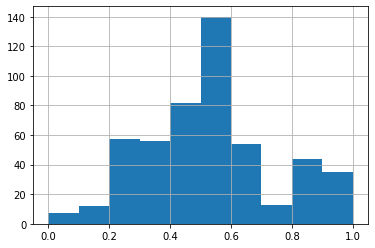

In [134]:
o = [f1_score_order_entry_func(y_, y_pred_) for y_, y_pred_ in zip(y_train[:500], model.predict(X_train[:500]))]
%matplotlib inline
pd.Series(o).hist()

In [135]:
y_pred = model.predict(X_train)

f1_score_order_func(y_train, y_pred)

0.5399746918111317

In [136]:
recall_score_order_func(y_train, y_pred)

0.9467926689576174

In [137]:
reduction_entry_func(4, y_pred)

0.23782932416953034

In [138]:
reduction_entry_func(4, y_train)

0.08626861397479954

In [140]:
y_pred = model.predict(X_test)

f1_score_order_func(y_test, y_pred)

0.34016422124298834

In [141]:
recall_score_order_func(y_test, y_pred)

0.6067351598173517

In [142]:
reduction_entry_func(4, y_pred)

0.2237442922374429

# Formulation [(o, kendall)]

In [3]:
from itertools import permutations
from scipy.stats import kendalltau
from operator import itemgetter

def calc_kendall(o1, good_os):
    
    all_kendall = [kendalltau(o, o1).correlation for o in good_os]
    
    max_kendall = max(all_kendall)
    
    return max_kendall

In [198]:
pd.Series([e.category for e in td if len(e.triples) == 3]).value_counts()

Food               353
WrittenWork        279
Building           229
Airport            211
SportsTeam         191
Astronaut           72
ComicsCharacter     72
University          66
Monument            47
dtype: int64

In [212]:
from sklearn.model_selection import train_test_split

# se há apenas uma tripla, não tenho o que ordenar
td_5 = [e for e in td if len(e.triples) == 4]

td_5_train, td_5_test = train_test_split(td_5, test_size=0.5, random_state=42)

def make_data(entries):

    data_train = set()

    for e_ix, e in enumerate(entries):

        good_orders = extract_orders(e)
        all_orders = permutations(e.triples)

        for o in all_orders:

            kendall = calc_kendall(o, good_orders)

            data = (o, e_ix, kendall)

            data_train.add(data)

    X = [(o, entries[e_ix], e_ix) for o, e_ix, _ in data_train]
    y = [kendall for o, e_ix, kendall in data_train]
    
    return X, y

X_train, y_train = make_data(td_5_train)
X_test, y_test = make_data(td_5_test)

In [213]:
len(y_train), sum(1 for y in y_train if y == 1.0)

(17472, 663)

In [214]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from itertools import permutations, product, combinations
from collections import Counter
from template_based2 import abstract_triples
from functools import reduce


def frac_siblings(o):
    
    i = 0
    current_s = None
    for o_ in o:
        if o_.subject == current_s:
            i += 1
        else:
            current_s = o_.subject
            
    subs = Counter(o_.subject for o_ in o)
    max_siblings = sum(v - 1 for v in subs.values())
    
    if max_siblings == 0:
        return 1.0
    
    return i / max_siblings

def frac_connections(o):
    
    n = 0
    for t, t_1 in zip(o[:-1], o[1:]):
        if t.object == t_1.subject:
            n += 1
    
    subs = set(t.subject for t in o)
    objs = set(t.object for t in o)
    
    len_intersect = len(subs.intersection(objs))
    if len_intersect:
        return n / len_intersect
    else:
        return 1

def is_first_the_main(o):
    
    subjs = set(t.subject for t in o)
    objs = set(t.object for t in o)
    
    s_not_o = subjs - objs
    
    return o[0].subject in s_not_o


class ExtractFeatures(TransformerMixin):
    
    def fit(self, X, y=None):
        
        self.freq_in_position = defaultdict(lambda: Counter())
        self.freq_all = Counter()
        self.freq_bigrams = Counter()
        self.freq_unigrams = Counter()
        
        entries = []
        seen = set()
        for o, e, e_ix in X:
            if e_ix not in seen:
                entries.append(e)
                seen.add(e_ix)
        
        for e in entries:
            for pos, t in enumerate(e.triples):
                self.freq_in_position[pos][t.predicate] += 1
                self.freq_unigrams[t.predicate] += 1
            
            for o in extract_orders(e):
                
                a_o = abstract_triples(o)
                
                self.freq_all[a_o] += 1
                
            for t1, t2 in zip(e.triples[:-1], e.triples[1:]):
                self.freq_bigrams[(t1.predicate, t2.predicate)] += 1
            
        return self
    
    def transform(self, X, y=None):
        
        return [self.extract_features(o, e) for (o, e, e_ix) in X]
        
    def extract_features(self, order, e):
        
        a_o = abstract_triples(order)
        a_o_pref = abstract_triples(order[:-1])
        
        freq_in_pos = {f'freq_in_pos_{i}': self.freq_in_position[i][order[i].predicate]
                       for i in range(len(order))}
        total_freq = max(sum(freq_in_pos.values()), 1)
        freq_in_pos = {k: v / total_freq for k, v in freq_in_pos.items()}
        
        naive_prob_predicates = reduce(lambda x, y: x*y,
                                       [(self.freq_bigrams[(t1.predicate, t2.predicate)] + 1) / (self.freq_unigrams[t1.predicate] + len(order))
                                        for t1, t2 in zip(order[:-1], order[1:])])
    
        features = {'freq_all': self.freq_all[a_o],
                    'kendall_from_original': kendalltau(e.triples, order).correlation,
                    'frac_connections': frac_connections(order),
                    'is_first_the_main': is_first_the_main(order),
                    'frac_siblings': frac_siblings(order),
                    'naive_prob_predicates': naive_prob_predicates
                   }
        features.update(freq_in_pos)
        
        return features

In [215]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

data_pipeline = Pipeline([
    ('extract', ExtractFeatures()),
    ('vectorizer', DictVectorizer(sparse=False, sort=False)),
    ('mms', MinMaxScaler())
])

pipeline = Pipeline([
    ('data', data_pipeline),
    ('clf', Lasso())
])

params_grid = {
    'clf__alpha': [10e-5, 10e-3, 1.0, 10]
}


cv = GridSearchCV(pipeline, params_grid, cv=3, return_train_score=True, scoring="neg_mean_squared_error")

In [216]:
cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('data',
                                        Pipeline(memory=None,
                                                 steps=[('extract',
                                                         <__main__.ExtractFeatures object at 0x0000023993173400>),
                                                        ('vectorizer',
                                                         DictVectorizer(dtype=<class 'numpy.float64'>,
                                                                        separator='=',
                                                                        sort=False,
                                                                        sparse=False)),
                                                        ('mms',
                                                         MinMaxScaler(copy=True,
                                

In [217]:
cv.cv_results_

{'mean_fit_time': array([4.25732374, 4.23796686, 4.54944022, 4.78841472]),
 'std_fit_time': array([0.12860371, 0.10055487, 0.34438779, 0.12316272]),
 'mean_score_time': array([2.18312112, 2.28638029, 2.28473028, 2.14301403]),
 'std_score_time': array([0.10809587, 0.20288713, 0.09488796, 0.03318789]),
 'param_clf__alpha': masked_array(data=[0.0001, 0.01, 1.0, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'clf__alpha': 0.0001},
  {'clf__alpha': 0.01},
  {'clf__alpha': 1.0},
  {'clf__alpha': 10}],
 'split0_test_score': array([-0.03017245, -0.03492865, -0.03761114, -0.03761114]),
 'split1_test_score': array([-0.03112582, -0.03590196, -0.03906405, -0.03906405]),
 'split2_test_score': array([-0.02952579, -0.03419131, -0.03699911, -0.03699911]),
 'mean_test_score': array([-0.03027469, -0.03500731, -0.03789143, -0.03789143]),
 'std_test_score': array([0.0006572 , 0.00070058, 0.00086599, 0.00086599]),
 'rank_test_score': a

In [218]:
import numpy as np

# 'mean_test_score': array([-0.04062265, -0.05654432, -0.05163638]),
# 'mean_test_score': array([-0.04471065, -0.05138794, -0.05776111]),
# 'mean_test_score': array([-0.04257936, -0.05973032, -0.05585099]),
# 'mean_test_score': array([-0.04240701, -0.05805845, -0.05585099]),
# 'mean_test_score': array([-0.04213137, -0.05692459, -0.05585099]),
# 'mean_test_score': array([-0.04330174, -0.05722233, -0.05585099]),
np.sqrt(-cv.best_score_) # 0.2080907045487102 ... 0.2059296160722554 0.206347679302091 0.2015506028032126 0.17021924438247926

0.17399622658476965

In [219]:
model = cv.best_estimator_
model

Pipeline(memory=None,
         steps=[('data',
                 Pipeline(memory=None,
                          steps=[('extract',
                                  <__main__.ExtractFeatures object at 0x0000023993173390>),
                                 ('vectorizer',
                                  DictVectorizer(dtype=<class 'numpy.float64'>,
                                                 separator='=', sort=False,
                                                 sparse=False)),
                                 ('mms',
                                  MinMaxScaler(copy=True,
                                               feature_range=(0, 1)))],
                          verbose=False)),
                ('clf',
                 Lasso(alpha=0.0001, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=None, selection='cyclic',
                       tol=0.0001, warm_start=Fal

In [66]:
def eval_ranking(model, e):
    
    good_orders = extract_orders(e)
    all_orders = list(permutations(e.triples))
    
    scores = model.predict([(o, e, 0) for o in all_orders])
    all_orders_sorted = [o for o, s in sorted(zip(all_orders, scores), key=lambda o: o[1], reverse=True)]
    
    good_positions = [all_orders_sorted.index(o) for o in good_orders]
    
    return min(good_positions), max(good_positions)

In [67]:
def score_model_func(model, entries):
    
    mins = []
    maxs = []

    for e in entries:
        
        min_pos, max_pos = eval_ranking(model, e)
        mins.append(min_pos)
        maxs.append(max_pos)
        
    return mins, maxs

In [104]:
import pandas as pd

mins, maxs = score_model_func(model, td_5_test)

#90%      12.500000
#95%      20.750000
#99%      52.000000

#50%        7.000000
#90%       51.000000
#95%       73.000000
pd.Series(mins).describe(percentiles=[.9, .95, .99])

count    177.000000
mean       0.677966
std        0.984667
min        0.000000
50%        0.000000
90%        2.000000
95%        3.000000
99%        4.000000
max        4.000000
dtype: float64

In [69]:
mins, maxs = score_model_func(model, td_5_train)

#90%        4.000000
#95%        6.000000
#99%       14.800000

#90%        1.00000
#95%        2.00000
#99%        3.00000
pd.Series(mins).describe(percentiles=[.9, .95, .99])

count    88.000000
mean      0.590909
std       1.699468
min       0.000000
50%       0.000000
90%       2.000000
95%       3.000000
99%       7.650000
max      12.000000
dtype: float64

In [96]:
y_pred = model.predict(X_train)

X_train_processed = model.steps[0][1][:-1].transform(X_train)

In [97]:
import pandas as pd

df = pd.DataFrame(X_train_processed, columns=model.steps[0][1][1].feature_names_)

df['y_true'] = y_train
df['y_pred'] = y_pred

In [108]:
def precision_recall(model, entries, n_max=10):
    
    total_returned = [0 for _ in range(n_max)]
    total_matched = [0 for _ in range(n_max)]
    total_good = [0 for _ in range(n_max)]
    
    for e in entries:
    
        good_orders = extract_orders(e)
        all_orders = list(permutations(e.triples))
        
        scores = model.predict([o, e, 0] for o in all_orders)
        all_orders_sorted = [o for o, s in sorted(zip(all_orders, scores), key=lambda o: o[1], reverse=True)]
        
        for i in range(1, n_max + 1):
            all_n_max = all_orders_sorted[:i]

            total_returned[i-1] += len(all_n_max)
            total_matched[i-1] += len(set(all_n_max).intersection(good_orders))
            total_good[i-1] += len(good_orders)
        
    precision = [m/r for m, r in zip(total_matched, total_returned)]
    recall = [m/g for m, g in zip(total_matched, total_good)]
    
    return precision, recall

In [220]:
precision, recall = precision_recall(model, td_5_test, 24)

Text(0.5, 1.0, 'Modelo')

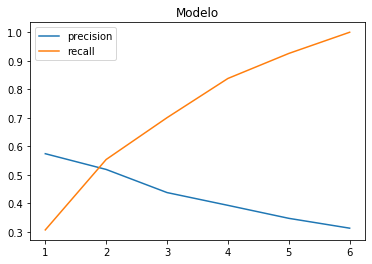

In [208]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(range(1, len(precision) + 1), precision, label='precision')
plt.plot(range(1, len(recall) + 1), recall, label='recall')
plt.legend()
plt.title('Modelo')

In [209]:
from random import shuffle

def precision_recall_random(entries, n_max=10):
    
    total_returned = [0 for _ in range(n_max)]
    total_matched = [0 for _ in range(n_max)]
    total_good = [0 for _ in range(n_max)]
    
    for e in entries:
    
        good_orders = extract_orders(e)
        all_orders = list(permutations(e.triples))
        shuffle(all_orders)
        
        all_orders_shuffled = list(all_orders)
        
        for i in range(1, n_max + 1):
            all_n_max = all_orders_shuffled[:i]

            total_returned[i-1] += len(all_n_max)
            total_matched[i-1] += len(set(all_n_max).intersection(good_orders))
            total_good[i-1] += len(good_orders)
        
    precision = [m/r for m, r in zip(total_matched, total_returned)]
    recall = [m/g for m, g in zip(total_matched, total_good)]
    
    return precision, recall

Text(0.5, 1.0, 'Random')

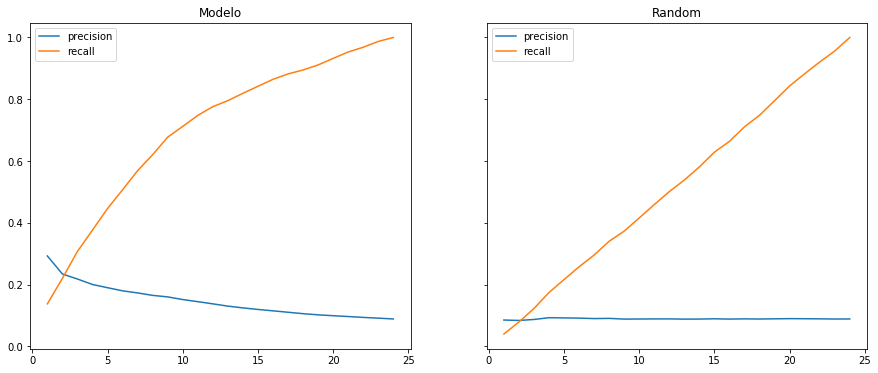

In [221]:
precision_rnd, recall_rnd = precision_recall_random(td_5_test, 24)

fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

axes[0].plot(range(1, len(precision) + 1), precision, label='precision')
axes[0].plot(range(1, len(recall) + 1), recall, label='recall')
axes[0].legend()
axes[0].set_title('Modelo')

axes[1].plot(range(1, len(precision_rnd) + 1), precision_rnd, label='precision')
axes[1].plot(range(1, len(recall_rnd) + 1), recall_rnd, label='recall')
axes[1].legend()
axes[1].set_title('Random')

# Evaluating scorer

In [58]:
import pickle
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
import sys
sys.path.append('../template_model')
from discourse_planning import get_sorter


models = {}
RMSEs = {}
stds = {}

with open('../data/templates/discourse_plan_data_extractors', 'rb') as f:
    fe = pickle.load(f)

for i in range(2, 8):

    data = np.load(f'../data/templates/discourse_plan_data_{i}.npy')

    X = data[:, :-1]
    y = data[:, -1]

    pipe = Pipeline([
        ('mms',  MinMaxScaler()),
        ('clf', Lasso(alpha=0.0001))
    ])
    
    RMSEs[i] = np.sqrt(-1*cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error'))
    stds[i] = np.std(y)

    pipe.fit(X, y)

    models[i] = pipe

sorter = get_sorter(models, fe)

In [59]:
rmse_df = pd.DataFrame(RMSEs)
rmse_df

,2,3,4,5,6,7
0,0.521878,0.249759,0.156305,0.131713,0.122567,0.111772
1,0.394780,0.260164,0.174781,0.153085,0.128174,0.116906
2,0.366356,0.286365,0.211971,0.175009,0.144113,0.134327
3,0.367822,0.286151,0.182684,0.133201,0.186188,0.134326
4,0.983871,1.194416,0.224118,0.175531,0.132898,0.112580


In [62]:
stats = rmse_df.describe().loc[['mean', 'std'], :].T
stats['y_std'] = pd.Series(stds)
stats

,mean,std,y_std
2,0.526941,0.263336,0.400108
3,0.455371,0.413451,0.263517
4,0.189972,0.027692,0.193201
5,0.153708,0.021417,0.157191
6,0.142788,0.025523,0.138502
7,0.121982,0.011437,0.123100


In [2]:
from gerar_base_discourse_planning import extract_orders
from itertools import permutations

def precision_recall(sorter, entries, n_max=10):
    
    total_returned = [0 for _ in range(n_max)]
    total_matched = [0 for _ in range(n_max)]
    total_good = [0 for _ in range(n_max)]
    
    for e in entries:
    
        good_orders = extract_orders(e)
        all_orders = list(permutations(e.triples))
        
        all_orders_sorted = sorter(all_orders, e)
        
        for i in range(1, n_max + 1):
            all_n_max = all_orders_sorted[:i]

            total_returned[i-1] += len(all_n_max)
            total_matched[i-1] += len(set(all_n_max).intersection(good_orders))
            total_good[i-1] += len(good_orders)
        
    precision = [m/r for m, r in zip(total_matched, total_returned)]
    recall = [m/g for m, g in zip(total_matched, total_good)]
    
    return precision, recall

In [3]:
from random import shuffle

def random_sorter(orders, e):
    my_orders = list(orders)
    shuffle(my_orders)
    
    return my_orders

In [4]:
from util import load_test, Entry

test = load_test()

In [11]:
import math

precisions, recalls = {}, {}

for i in range(2, 8):
    
    N = math.factorial(i)

    td_ = [t for t in test if len(t.triples) == i]
    
    precision, recall = precision_recall(sorter, td_, N)
    
    precisions[i] = precision
    recalls[i] = recall

In [12]:
precisions_rnd, recalls_rnd = {}, {}

for i in range(2, 8):
    
    N = math.factorial(i)

    td_ = [t for t in test if len(t.triples) == i]
    
    precision_rnd, recall_rnd = precision_recall(random_sorter, td_, N)
    
    precisions_rnd[i] = precision_rnd
    recalls_rnd[i] = recall_rnd

In [25]:
recall_a_10pct = {}

for i in range(2, 8):
    
    N = math.factorial(i)
    pct_10 = math.ceil(N*0.1)
    
    recall_a_10pct[i] = (recalls[i][pct_10 - 1], recalls_rnd[i][pct_10 - 1])

In [27]:
import pandas as pd

df = pd.DataFrame(recall_a_10pct).T
df.columns = ['Modelo', 'Random']

df

,Modelo,Random
2,0.565637,0.486486
3,0.347384,0.168605
4,0.290984,0.131148
5,0.474820,0.082734
6,0.446809,0.106383
7,0.488372,0.186047


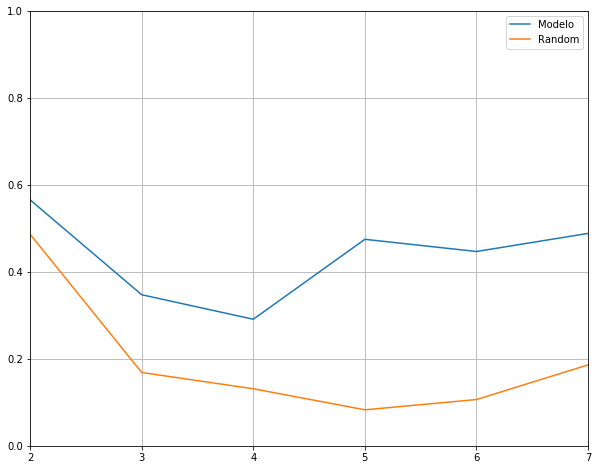

In [32]:
%matplotlib inline
df.plot(ylim=(0.0, 1.0), figsize=(10, 8), grid=True)

Text(0.5, 1.0, 'Random')

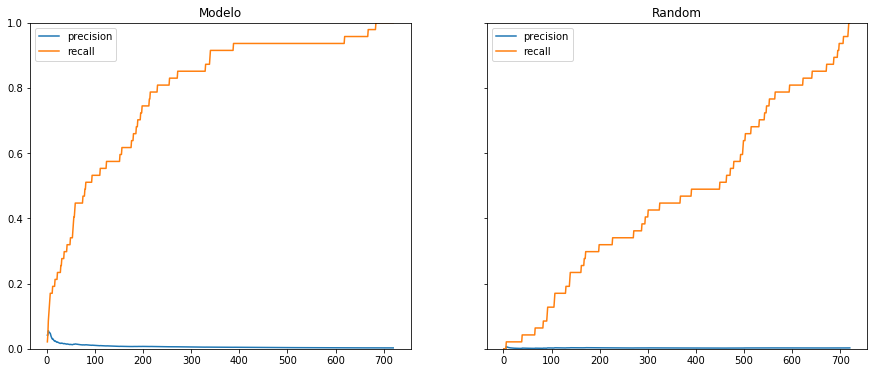

In [33]:
from matplotlib import pyplot as plt
import math
%matplotlib inline

n_triples = 6
N = math.factorial(n_triples)

td_ = [t for t in test if len(t.triples) == n_triples]

precision, recall = precision_recall(sorter, td_, N)
precision_rnd, recall_rnd = precision_recall(random_sorter, td_, N)

fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

axes[0].plot(range(1, len(precision) + 1), precision, label='precision')
axes[0].plot(range(1, len(recall) + 1), recall, label='recall')
axes[0].legend()
axes[0].set_title('Modelo')
axes[0].set_ylim(0.0, 1.0)

axes[1].plot(range(1, len(precision_rnd) + 1), precision_rnd, label='precision')
axes[1].plot(range(1, len(recall_rnd) + 1), recall_rnd, label='recall')
axes[1].legend()
axes[1].set_title('Random')